# Data Cleaning, Feature Selection and Feature Engineering

**In this notebook, I apply data cleaning and feature selection techniques to the datasets to prepare them for modeling. In addition, I create features that summarize a combination of features originally contained in the data.**


## Importing modules and clean data

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.stats as stats

sns.set_style('dark')
plt.style.use('seaborn')
%matplotlib inline

data = '../data/housing_clean.csv'
test_data = '../data/test_clean.csv'
housing = pd.read_csv(data)
test = pd.read_csv(test_data)

## Outlier selection

Let's examine our strongly correlated variables since any outliers in those features will affect our models more signficantly:

### Overall quality

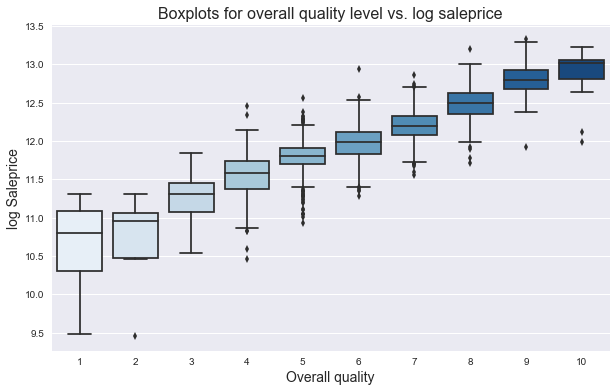

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(housing['overall_qual'], housing.saleprice, palette='Blues')
plt.title('Boxplots for overall quality level vs. log saleprice', size=16)
plt.xlabel('Overall quality', size=14)
plt.ylabel('log Saleprice', size=14);

We see that there are signficantly low outliers for price for houses with quality 2, 9, and 10. While outliers on the high end make sense in a positively linear relationship between quality and price, the low outliers probably have their prices reduced by some other factor. 

Let's look at the rows for those outliers and keep them in mind:

In [41]:
compare = ['saleprice', 'overall_qual']

In [42]:
housing[(housing['overall_qual'] == 2) & (housing['saleprice']< 10)][compare]

,saleprice,overall_qual
1628,9.456419,2


This gives us the $log$ saleprice for the quality 2 outlier. If we exponentiate it, we get an approximate value in dollars:

In [43]:
np.expm1(9.456419)

12789.001348412834

We see that this house sold for only $12800 (which seems quite low).

Let's look at the prices for the quality 9/10 outliers:

In [44]:
housing[((housing['overall_qual'] == 9) | (housing['overall_qual'] == 10)) & (housing['saleprice']< 12.3)][compare]

,saleprice,overall_qual
125,11.918397,9
960,11.982935,10
1885,12.121881,10


Let's exponentiate our saleprices for these three houses:

In [45]:
[np.expm1(x) for x in [11.91, 11.98, 12.12]]

[148745.67943014178, 159531.0306232254, 183504.51490438476]

These three homes sold for under $200,000.

In [46]:
np.expm1(housing[((housing['overall_qual'] == 9) | (housing['overall_qual'] == 10))].saleprice.mean())

369846.30266367417

Looking at the average sale price for condition 9 or 10 homes, the three homes listed above are well below the mean.

### Above ground living area

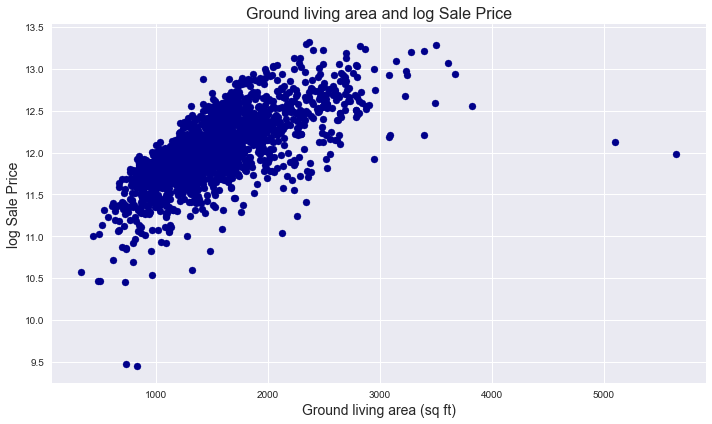

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(housing['gr_liv_area'], housing.saleprice, c='darkblue')
plt.title('Ground living area and log Sale Price', size=16)
plt.xlabel('Ground living area (sq ft)', size=14)
plt.ylabel('log Sale Price', size=14);
plt.tight_layout()

**We see that there are some noticeable outliers with high area but relatively low price and some with low area and extremely low price:**

In [48]:
housing[(housing['gr_liv_area'] > 5000) & (housing['saleprice'] < 12.5)]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
960,1499,908154235,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,...,0,480,Gd,None,None,0,1,2008,New,11.982935
1885,2181,908154195,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,...,0,0,None,None,Elev,17000,10,2007,New,12.121881


**House ID 1499 and 2181 are our outliers. It is likely that these homes are on large lots closer to agricultural zones and thus have low values even though they represent large, high-quality properties. Let's drop these rows:**

In [49]:
housing.drop([960, 1885], axis=0, inplace=True)

**Looking at the distribution of ground living area again, we see a less skewed distribution:**

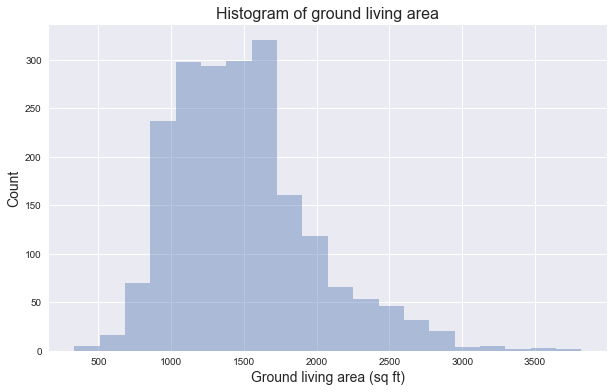

In [50]:
plt.figure(figsize=(10, 6))
sns.distplot(housing.gr_liv_area, bins=20, kde=False)
plt.title('Histogram of ground living area', size=16)
plt.xlabel('Ground living area (sq ft)', size=14)
plt.ylabel('Count', size=14);

### Low area outliers

In [51]:
housing[(housing['gr_liv_area'] < 1000) & (housing['saleprice'] < 10)]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
183,1554,910251050,20,A (agr),80.0,14584,Pave,Reg,Low,AllPub,...,0,0,None,None,None,0,2,2008,WD,9.480444
1628,182,902207130,30,RM,68.0,9656,Pave,Reg,Lvl,AllPub,...,0,0,None,None,None,0,6,2010,WD,9.456419


**Let's drop these observations as well.**

In [52]:
housing.drop([183, 1628], axis=0, inplace=True)

###  Lot area

Let's look at the distribution of this feature first:

Text(0.5,1,'Boxplot of lot area')

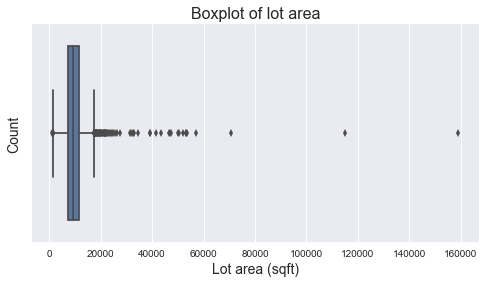

In [53]:
plt.figure(figsize=(8, 4))
sns.boxplot(housing.lot_area)
plt.ylabel('Count', size=14)
plt.xlabel('Lot area (sqft)', size=14)
plt.title('Boxplot of lot area', size=16)

**It is evident that the distribution is heavily skewed; let's inspect the two most noticeable outliers:**

In [54]:
housing[housing.lot_area > 100000]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
471,2116,906426060,50,RL,68.0,159000,Pave,IR2,Low,AllPub,...,0,0,None,None,Shed,500,6,2007,WD,12.531776
694,2072,905301050,20,RL,68.0,115149,Pave,IR2,Low,AllPub,...,0,0,None,None,None,0,6,2007,WD,12.618186


**Let's drop these rows:**

In [55]:
housing.drop([471, 694], axis=0, inplace=True)

### Lot frontage

In [56]:
housing[(housing['lot_frontage'] > 200) & (housing['saleprice'] < 13)]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
1335,1266,535427070,20,RL,313.0,27650,Pave,IR2,HLS,AllPub,...,0,0,None,None,None,0,11,2008,WD,12.396697


In [57]:
housing.drop(1335, axis=0, inplace=True)

## Feature Engineering

Several of our features can be summariezed in a single column. Let's construct 2 features that summarize multiple columns:   
1) total_baths - The total number of bathrooms in the home  
2) total_outdoor - the total area of outdoor surrounded areas (decks and porches)

In [58]:
housing['total_baths'] = housing['bsmt_full_bath'] + 0.5*housing['bsmt_half_bath'] + housing['full_bath'] + 0.5*housing['half_bath']

In [59]:
housing['total_outdoor'] = housing['wood_deck_sf'] + housing['enclosed_porch'] + housing['3ssn_porch'] + housing['open_porch_sf'] + housing['screen_porch']

In [60]:
test['total_baths'] = test['bsmt_full_bath'] + 0.5*test['bsmt_half_bath'] + test['full_bath'] + 0.5*test['half_bath']

In [61]:
test['total_outdoor'] = test['wood_deck_sf'] + test['enclosed_porch'] + test['3ssn_porch'] + test['open_porch_sf'] + test['screen_porch']

Let's drop the individual parts now:

In [62]:
bath_vars = ['total_baths', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath']
outdoor_var = ['wood_deck_sf', 'enclosed_porch', '3ssn_porch', 'open_porch_sf', 'screen_porch']

housing.drop(bath_vars + outdoor_var, axis=1, inplace=True)
test.drop(bath_vars + outdoor_var, axis=1, inplace=True)

Since we already have a total basement size column, let's remove the individual components of that variable as well:

In [63]:
bsmt_vars = ['bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'low_qual_fin_sf']

housing.drop(bsmt_vars, axis=1, inplace=True)
test.drop(bsmt_vars, axis=1, inplace=True)

### Dropping/redefining columns with low counts

#### Kitchens above ground

In [64]:
housing.kitchen_abvgr.value_counts()

1    1953
2      88
0       2
3       1
Name: kitchen_abvgr, dtype: int64

A large majority of the homes have only 1 kitchen above ground. Let's drop this column.

In [65]:
housing.drop('kitchen_abvgr', 1, inplace=True)
test.drop('kitchen_abvgr', 1, inplace=True)

#### Fireplaces

In [66]:
housing.fireplaces.value_counts()

0    999
1    896
2    143
3      5
4      1
Name: fireplaces, dtype: int64

Most houses have either 1 or no fireplace. Let's define the column to just show whether or not the house had a fireplace:

In [67]:
housing['fireplaces'] = housing['fireplaces'].map({0: 0, 1:1, 2:1, 3:1, 4:1})

In [68]:
housing.fireplaces.value_counts()

1    1045
0     999
Name: fireplaces, dtype: int64

#### Street

In [69]:
housing.street.value_counts()

Pave    2037
Grvl       7
Name: street, dtype: int64

Only 7 homes have access to a gravel road. Let's drop this column.

In [70]:
housing.drop('street', axis=1, inplace=True)
test.drop('street', axis=1, inplace=True)

#### Pools

Less than 10 homes have pools. Let's drop the columns related to pools:

In [71]:
housing.drop(['pool_area', 'pool_qc'], axis=1, inplace=True)

In [72]:
test.drop(['pool_area', 'pool_qc'], axis=1, inplace=True)

#### Utilities

While `utilities` has 3 classes, all but 1 observation were in the AllPub class:

In [73]:
housing['utilities'].value_counts()

AllPub    2042
NoSewr       1
NoSeWa       1
Name: utilities, dtype: int64

In [74]:
housing.drop('utilities', axis=1, inplace=True)
test.drop('utilities', axis=1, inplace=True)

#### Misc Features

Most of the homes don't have an additional miscellaneous feature:

In [75]:
housing.misc_feature.value_counts()

None    1981
Shed      55
Gar2       4
Othr       3
TenC       1
Name: misc_feature, dtype: int64

Let's drop this column and the corresponding `misc_val`:

In [76]:
housing.drop(['misc_feature', 'misc_val'], axis=1, inplace=True)

test.drop(['misc_feature', 'misc_val'], axis=1, inplace=True)

#### Fence

Most homes don't have a fence:

In [77]:
housing.fence.value_counts()

None     1644
MnPrv     227
GdPrv      83
GdWo       80
MnWw       10
Name: fence, dtype: int64

In [78]:
housing.drop('fence', axis=1, inplace=True)

In [79]:
test.drop('fence', axis=1, inplace=True)

## Converting numeric variables to categorical

I identified the numeric and categorical variables based on the output of the `plotting` function. We can see that some features are encoded as numeric but represent categories. 

In [80]:
catcols = ['ms_subclass', 'mo_sold', 'yr_sold', 'bedroom_abvgr', 'fireplaces']

Then we convert the numeric variables contained in `catcols` into categorical ones:

In [81]:
housing[catcols] = housing[catcols].astype(str)

test[catcols] = test[catcols].astype(str)

## Deskewing features

It would make sense for some of the numeric features to be skewed (there's a lower bound on many features required in a house, but the upper bound would only be constrained by the desires and resources of the land owner). Let's examine the skew of the numeric features:

In [82]:
numerics = [x for x in housing.select_dtypes(exclude='object').columns if x not in ['id', 'pid', 'saleprice']]

In [83]:
for x in housing[numerics].columns:
    print('The skew for', x, 'is', stats.skew(housing[x]))

The skew for lot_frontage is 0.6841258321149609
The skew for lot_area is 3.9671150137214517
The skew for overall_qual is 0.16692694416537374
The skew for overall_cond is 0.6542783677681044
The skew for year_built is -0.609730716625067
The skew for year_remod/add is -0.4494606909404276
The skew for mas_vnr_area is 2.57700915260858
The skew for total_bsmt_sf is 0.4315662125451783
The skew for 1st_flr_sf is 0.9643296060419451
The skew for 2nd_flr_sf is 0.8732447733508828
The skew for gr_liv_area is 0.9294837878950134
The skew for totrms_abvgrd is 0.778843231249695
The skew for garage_cars is -0.22679116190615453
The skew for garage_area is 0.1561792005283305
The skew for total_outdoor is 1.3551559142569771


Let's log transform features with skew > 0.8 to make them closer to normal:

In [84]:
for x in housing[numerics].columns:
    if stats.skew(housing[x]) > .8:
        housing[x] = np.log1p(housing[x])
    else:
        housing[x]

In [85]:
for x in housing[numerics].columns:
    print('The skew for', x, 'is', stats.skew(housing[x]))

The skew for lot_frontage is 0.6841258321149609
The skew for lot_area is -0.7940672506294796
The skew for overall_qual is 0.16692694416537374
The skew for overall_cond is 0.6542783677681044
The skew for year_built is -0.609730716625067
The skew for year_remod/add is -0.4494606909404276
The skew for mas_vnr_area is 0.5440242910010953
The skew for total_bsmt_sf is 0.4315662125451783
The skew for 1st_flr_sf is -0.05050338105437545
The skew for 2nd_flr_sf is 0.3403106828635344
The skew for gr_liv_area is -0.053442455797723235
The skew for totrms_abvgrd is 0.778843231249695
The skew for garage_cars is -0.22679116190615453
The skew for garage_area is 0.1561792005283305
The skew for total_outdoor is -1.3555230416959734


Let's look closer at some of the skewed variables:

Some of these variables are skewed because of a presence of two modes (one for those with the feature and 0 for homes without the feature). Let's convert the variables with this nature to be 1/0 categorical or drop them in favor of continuous ones:

In [86]:
housing['has_masonry'] = np.where(housing['mas_vnr_area'] != 0 , 1, 0)
housing['has_2nd_flr'] = np.where(housing['2nd_flr_sf'] !=0, 1, 0)
housing['has_garage'] = np.where(housing['garage_cars'] !=0, 1, 0)
housing['has_outdoor'] = np.where(housing['total_outdoor'] !=0, 1, 0)

test['has_masonry'] = np.where(test['mas_vnr_area'] != 0 , 1, 0)
test['has_2nd_flr'] = np.where(test['2nd_flr_sf'] !=0, 1, 0)
test['has_garage'] = np.where(test['garage_cars'] !=0, 1, 0)
test['has_outdoor'] = np.where(test['total_outdoor'] !=0, 1, 0)

In [87]:
housing.drop('total_outdoor', axis=1, inplace=True)
test.drop('total_outdoor', axis=1, inplace=True)

In [88]:
garage_vars = [x for x in housing.columns if 'gar' in x]

garage_vars.remove('has_garage')

housing.drop(garage_vars, axis=1, inplace=True)
test.drop(garage_vars, axis=1, inplace=True)

In [89]:
housing.drop(columns=['mas_vnr_type', 'mas_vnr_area'], axis=1, inplace=True)
test.drop(columns=['mas_vnr_type', 'mas_vnr_area'], axis=1, inplace=True)

In [90]:
housing.drop('2nd_flr_sf', axis=1, inplace=True)
test.drop('2nd_flr_sf', axis=1, inplace=True)

Since lot frontage and lot area are be highly correlated, let's drop lot frontage as it encodes less information.

In [91]:
housing.drop('lot_frontage', axis=1, inplace=True)
test.drop('lot_frontage', axis=1, inplace=True)

## Generate dummy variables

First, we generate a list of columns that are non-numeric (including those we converted above) and assign them to the variable `to_be_dummies`:

In [92]:
to_be_dummies = housing.select_dtypes(include='object').columns

In [93]:
len(to_be_dummies)

36

Then we create dummies for those columns:

In [94]:
housing = pd.get_dummies(housing, columns=to_be_dummies)

Now let's do the same with the test set to prepare it for modeling:

In [95]:
test[catcols] = test[catcols].astype(str)

test_dummies = test.select_dtypes(include='object').columns

test = pd.get_dummies(test, columns=test_dummies)

### Checking shape of datasets

In [96]:
housing.shape, test.shape

((2044, 274), (879, 261))

We can see that there are several dummy categories that didn't show up in the test set (since the number of columns in the training data exceeds that number in the test data). Let's examine the value counts of those variables:

In [97]:
not_in_test = set(housing.columns)^set(test.columns)

only_in_test = []

for i in not_in_test:
    try:
        housing[i].value_counts()
    except:
        only_in_test.append(i)

Based on the above output, we see that many of the categories have very low value counts (<10). Let's remove those categories (in addition to those dummies that are in the test data but not in the train data): 

In [98]:
dummies_to_drop = [x for x in not_in_test if x not in ['overall_qual_10', 'saleprice', 'ms_zoning_C', 'garage_qual_Fa',\
                                                       'bsmt_cond_Fa'] + only_in_test]

housing.drop(axis=1, columns=dummies_to_drop, inplace=True)

test.drop(axis=1, columns=only_in_test, inplace=True)

In [99]:
in_train = list(set(housing.columns)-set(test.columns))

in_train.remove('saleprice')

for col in in_train:
    test[col] = 0

no_target = [x for x in housing.columns if x != 'saleprice']

test = test[housing[no_target].columns]

In [100]:
housing.shape

(2044, 252)

## Exporting for modeling

Now we export these data to use in the modeling worksheet:

In [101]:
housing.to_csv('../data/train_model_ready.csv', index=False)
test.to_csv('../data/test_model_ready.csv', index=False)

In [102]:
housing.shape, test.shape

((2044, 252), (879, 251))